In [21]:
from transformer_lens import HookedTransformer
from sae_lens import SAE
import torch

device = "cpu"

model = HookedTransformer.from_pretrained("google/gemma-2-2b", device = device)

Loading checkpoint shards: 100%|██████████| 3/3 [01:39<00:00, 33.14s/it]


Loaded pretrained model google/gemma-2-2b into HookedTransformer


In [1]:
import json
import numpy as np
with open("/proj/inductive-bias/llama/sae/cache/steering_in_sae_space/steering_directions.json", "r") as file:
    steering_directions_json = json.load(file)
steering_directions = {}
for layer in steering_directions_json:
    steering_directions[int(layer)] = np.array(steering_directions_json[layer])
with open("/proj/inductive-bias/llama/sae/cache/steering_in_sae_space/stds.json", "r") as file:
    stds_json = json.load(file)
stds = {}
for layer in stds_json:
    stds[int(layer)] = stds_json[layer]

In [11]:
from sae_lens import SAE
threses = [500, 200, 10, 100, 1]
steering_directions_in_attn_space = {thres: {} for thres in threses}
for layer in range(26):
    sae, cfg_dict, _ = SAE.from_pretrained(
        release = "gemma-scope-2b-pt-att-canonical",
        sae_id = f"layer_{layer}/width_16k/canonical",
        device = device
    )
    for thres in threses:
        inds = np.argsort(-np.abs(steering_directions[layer]))[:thres]
        steering_direction = np.zeros(steering_directions[layer].shape)
        steering_direction[inds] = steering_directions[layer][inds]
        steering_directions_in_attn_space[thres][layer] = (steering_direction @ sae.W_dec.detach().cpu().numpy())

import json
for thres in threses:
    with open(f"cache/steering_in_full_attn_space/steering_directions_abs_thres_{thres}.json", "w") as file:
        json.dump({str(layer): direction.tolist() for layer, direction in steering_directions_in_attn_space[thres].items()}, file)

/proj/inductive-bias.shadow/abakalov.anaconda/envs/sae/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


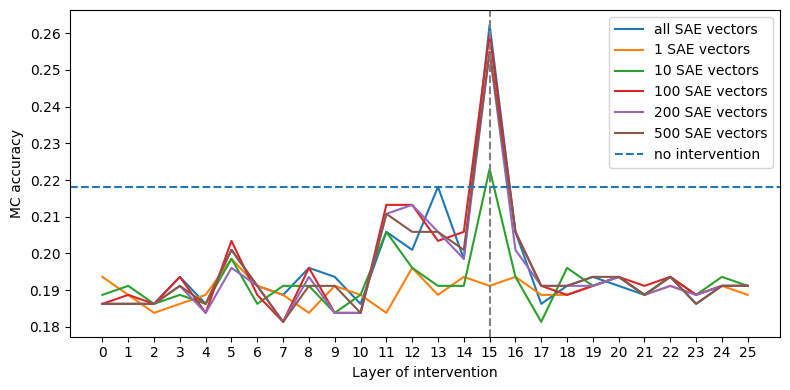

In [7]:
import json
with open("/proj/inductive-bias/llama/sae/cache/accuracies_gemma/acc-alpha-5-full-sae.json", "r") as file:
    accs_full = json.load(file)
    accs_full = {int(layer): accs_full[layer] for layer in accs_full}
threses = [1, 10, 100, 200, 500]
accs_abs_thres = []
for thres in threses:
    with open(f"/proj/inductive-bias/llama/sae/cache/accuracies_gemma/acc-alpha-5-abs-thres-{thres}-vectors-sae.json", "r") as file:
        accs_1 = json.load(file)
        accs_1 = {int(layer): accs_1[layer] for layer in accs_1}
        accs_abs_thres.append(accs_1)
acc_no_intervention = 0.2181372549019608

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1)
fig.set_size_inches((8, 4))
axs.plot([v for k, v in accs_full.items()], label="all SAE vectors")
for thres, acc in zip(threses, accs_abs_thres):
    axs.plot([v for k, v in acc.items()], label=f"{thres} SAE vectors")
axs.axhline(acc_no_intervention, label="no intervention", linestyle="--")
axs.axvline(15, linestyle="--", c="grey")
axs.set_xticks(range(26))
axs.set_xlabel("Layer of intervention")
axs.set_ylabel("MC accuracy")
axs.legend()
fig.tight_layout()
plt.savefig("images/sae_acc_by_layers_abs_thres.png")

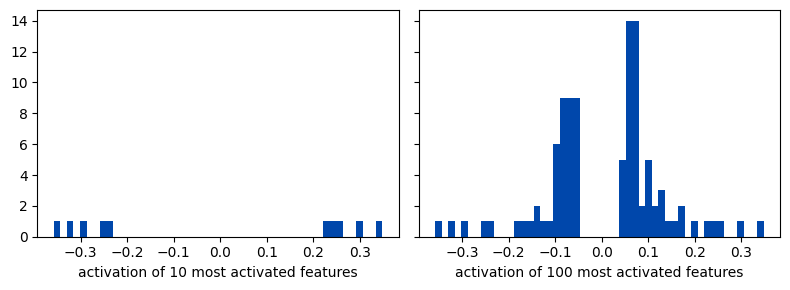

In [47]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, sharey=True)
fig.set_size_inches((8, 3))
ax[0].hist(steering_direction_on_inds_10, bins=50, color="#0047AB")
ax[1].hist(steering_direction_on_inds_100, bins=50, color="#0047AB")

ax[0].set_xlabel("activation of 10 most activated features")
ax[1].set_xlabel("activation of 100 most activated features")
fig.tight_layout()
plt.savefig("images/activation_dist.png")

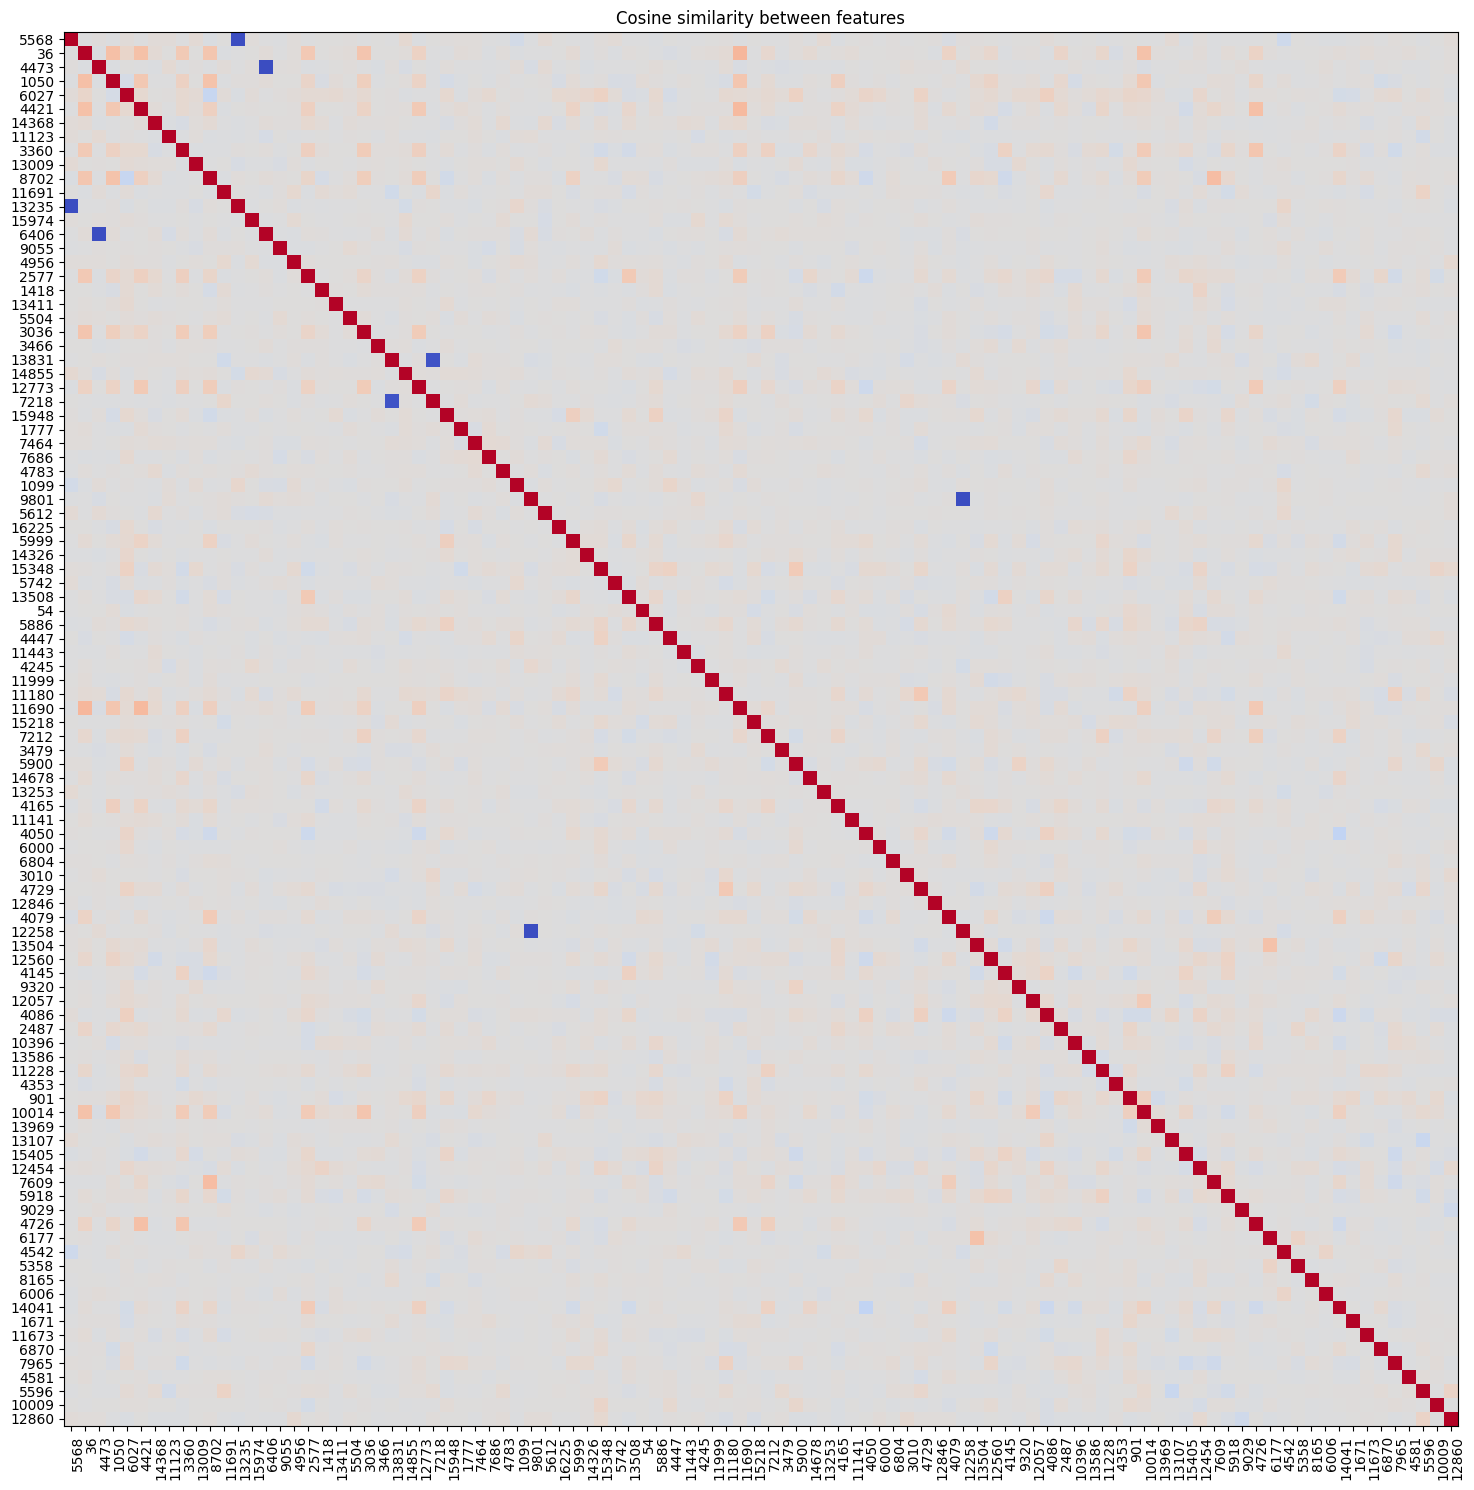

In [25]:
import numpy as np

sims = np.zeros((len(vectors), len(vectors)))
for i, v1 in enumerate(vectors):
    for j, v2 in enumerate(vectors):
        sims[i, j] = (v1.detach().numpy() @ v2.detach().numpy()) / np.linalg.norm(v1.detach().numpy()) / np.linalg.norm(v2.detach().numpy())
        
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches((15, 15))
im = ax.imshow(sims, cmap="coolwarm", vmax=1, vmin=-1)

ax.set_xticks(np.arange(len(inds)), labels=inds)
ax.set_yticks(np.arange(len(inds)), labels=inds)

plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

ax.set_title("Cosine similarity between features")
fig.tight_layout()
plt.savefig("images/cosine_sim_features_100.png")